# Plot the initial condition of the dynamic rupture simulation

2024.6.23 Kurama Okubo

<!-- - 2024.6.25 update for the full range of stress from zero to maximum.
- 2024.07.10 update for the new long Ds parameters
- 2024.09.04 update for the new event set
- 2024.12.23 update for the new catalog -->

- 2025.1.30 Clean up the notebook for the master plot.

In [35]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib as mpl

%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

import seaborn as sns
from matplotlib.collections import LineCollection

import pickle 

from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes # not compatible with bbox_inches=tight


%load_ext autoreload
%autoreload 2


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
figdir = "../figure/02_initialcondition"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [37]:
E = 96e9
nu = 0.246 # metagabbro
mu = E/(2*(1+nu))

a_patch = 4.0e-3
a_nuc = 2.5e-3
a_margin = 4.08e-3

rupturetype = "pulse" # the initial model is same with both pulse and crack.
pdcscaling= 0.6 #0.6 #0.65
bgbeta= 0.35 #0.4
# gammautry = 0.8

sig_n = 6e6

nb_x_elements = 1024 #128 #128 #128
nb_z_elements = 1024 #128 #128 #128

IfBinaryOutput = True

Ifmasteroutput=True # add file key to the master output
if Ifmasteroutput:
    filekey = "_master"
else:
    filekey = ""

    

In [38]:
# case study parameter casename
casestr = f"a={a_patch*1e3:.2f}_ruptype={rupturetype}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

# finame=f"../../preprocess_modelsetup/data/gouge_dynamicrupture_modelparam_{casestr}.csv"
finame=f"../../preprocess_modelsetup/data/gouge_dynamicrupture_modelparam_{casestr}{filekey}.csv"

# Read model parameters
df_modelparam = pd.read_csv(finame, index_col=0)


datadir_root = "../../../uguca/build_v42_masterfitmodel/simulations_main_casestudy"

# datadir_root = "/Volumes/4mGouge_WorkHDD/RuptureSimulation/build_hpcv41_newcatalog_master/simulations_main_casestudy_hpc"
datadir_root = "/Volumes/Okuboetal2025_masterHDD/RuptureSimulation/main_casestudy/build_hpcv62_mastercase_v3/simulations_main_casestudy_hpc_master"

casestr

'a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35'

In [39]:
df_modelparam["delsigma_factor"]

gougeevent_id
4      0.600
9      0.600
18     0.600
19     0.600
20     0.600
21     0.600
24     0.695
27     0.600
31     0.600
38     0.600
40     0.600
43     0.600
44     0.600
50     0.500
52     0.460
61     0.600
62     0.600
69     0.600
72     0.430
77     0.600
85     0.600
88     0.600
89     0.600
95     0.600
99     0.600
100    0.600
109    0.600
118    0.600
120    0.600
126    0.600
128    0.600
129    0.410
131    0.600
Name: delsigma_factor, dtype: float64

In [40]:
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL08" # the color dict is same for all the sensor although separately saved.
gougepatch_id = "G3"
with open(f'../../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

# Read and compute the cross-section values

To plot the cross-section, we read the gouge event cases from the output of numerical simulation and extract the profile of shear stress and normal stress.

In [41]:
# read the time and coordinates
expr_id = 87
gougeevent_id = 72
df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id]
# simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"
simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{df_modelparam_selected.delsigma_factor.values[0]:.4f}_initcondition"
print(f"Process {gougeevent_id}: {simulation_name}")

df_time = pd.read_csv(os.path.join(datadir_root,simulation_name+".time"), header=None, sep=' ', index_col=0)
df_coord = pd.read_csv(os.path.join(datadir_root,simulation_name+".coords"), header=None, sep=' ', index_col=None)
NT=len(df_time)


# location of the center of nucleation zone
nuc_x = -(a_patch - a_nuc)
nuc_z = 0

xcoord = df_coord.loc[:,0].values
zcoord = df_coord.loc[:,2].values

x_length = xcoord.max()
z_length = zcoord.max()

# ref also: https://stackoverflow.com/a/35176314
dgrid = (zcoord[1] - zcoord[0])
print(f"Grid size: {dgrid*1e3}[mm]") 

X = xcoord.reshape(nb_x_elements,nb_z_elements).T- dgrid/2 - x_length/2
Z = zcoord.reshape(nb_x_elements,nb_z_elements).T- dgrid/2 - z_length/2



Process 72: fb03-087__0072_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4300_initcondition
Grid size: 0.0390625[mm]


In [42]:
df_modelparam_selected.delsigma_factor

gougeevent_id
72    0.43
Name: delsigma_factor, dtype: float64

In [43]:
# gougeevent_ids = [30, 71, 3, 51, 104]
gougeevent_ids = [24, 50, 52, 72, 129]

In [44]:
df_modelparam_selected.columns

Index(['M0_mean', 'Tw_mean', 'Mw_mean', 'hat_sn_patch', 'hat_sn_background',
       'delsig_withmargin_try', 'slip_try', 'initialstress_fraction',
       'delsigma_factor', 'fp_patch', 'hat_fr', 'hat_fp_background',
       'hat_fr_background', 'dc_try', 'hat_ds_factor_rapidnuc_nuc',
       'hat_ds_factor_rapidnuc_patch', 'tau_c_nuc', 'tau_r_nuc', 'tau_c_patch',
       'tau_r_patch', 'tau_c_background', 'tau_r_background', 'tau_0_nuc',
       'tau_0_patch', 'tau_0_background', 'GIIC_nuc', 'GIIC_patch',
       'GIIC_background', 'Sratio_nuc', 'Sratio_patch', 'Ainit_nuc',
       'Ainit_patch', 'Anuc_nuc', 'Anuc_patch', 'rnuc_nuc', 'rnuc_patch'],
      dtype='object')

In [45]:
t_plot_target = 0.0

crosssec_all = dict()

for gougeevent_id in gougeevent_ids:
    
    # gougeevent_id = 30
    df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id]
    # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"
    simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{df_modelparam_selected.delsigma_factor.values[0]:.4f}_initcondition"

    print(f"Process {gougeevent_id}: {simulation_name}")

    fp_patch = df_modelparam_selected["fp_patch"].values[0]
    fr_patch = df_modelparam_selected["hat_fr"].values[0]
    
    hat_fp_background = df_modelparam_selected["hat_fp_background"].values[0]
    hat_fr_background = df_modelparam_selected["hat_fr_background"].values[0]

    read_comp = 0 #0: Mode II direction, 1: normal (Mode I), 2:Mode III direction 

    # read cohesion (shear traction)
    read_parameter = f"cohesion_{read_comp}" # select the parameter to read
    if IfBinaryOutput:
        D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
        df_data_coh = pd.DataFrame(data=D.reshape((NT, -1)))
    else:
        df_data_coh = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")

    # check if the grid size is consistent to the data shape
    assert len(df_data_coh.columns) == len(xcoord)

    read_comp = 1 #0: Mode II direction, 1: normal (Mode I), 2:Mode III direction 

    # read cohesion (shear traction)
    read_parameter = f"cohesion_{read_comp}" # select the parameter to read
    if IfBinaryOutput:
        D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
        df_data_sn = pd.DataFrame(data=D.reshape((NT, -1)))
    else:
        df_data_sn = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")


    # check if the grid size is consistent to the data shape
    assert len(df_data_sn.columns) == len(xcoord)

    
    # Shear stress
    # t_plot_target = t_plot_list[i]
    t_plot_ind = np.where(df_time>=t_plot_target)[0][0]
    print(t_plot_ind)
    t_plot_true = df_time.iloc[t_plot_ind].values[0]

    data_coh = df_data_coh.loc[t_plot_ind, :].copy().values
    data_sn = df_data_sn.loc[t_plot_ind, :].copy().values

    V_coh = data_coh.reshape(nb_x_elements,nb_z_elements).T
    V_sn = data_sn.reshape(nb_x_elements,nb_z_elements).T

    # Compute peak strength
    # select the data within the patch
    data_taup = np.zeros(len(data_sn))
    data_taur = np.zeros(len(data_sn))
    for i, (x0, z0) in enumerate(zip(xcoord, zcoord)):
        if np.sqrt((x0- dgrid/2 - x_length/2)**2+(z0- dgrid/2 - z_length/2)**2) <= a_patch:
            # within the patch
            data_taup[i] = data_sn[i] * fp_patch # fp is same within the nucleation and patch regions
            data_taur[i] = data_sn[i] * fr_patch # fr is same within the nucleation and patch regions
        else:
            data_taup[i] = data_sn[i] * hat_fp_background
            data_taur[i] = data_sn[i] * hat_fr_background

    V_taup = -data_taup.reshape(nb_x_elements,nb_z_elements).T
    V_taur = -data_taur.reshape(nb_x_elements,nb_z_elements).T

    data_coh = df_data_coh.loc[t_plot_ind, :].values
    data_taup[data_taup==0] = 1e-6 # avoid zero division
    data_cohovertaup = data_coh/(-data_taup)

    V_cvt = data_cohovertaup.reshape(nb_x_elements,nb_z_elements).T

    # search the cross_section
    x_crosssec_ind = np.where(np.abs(Z[:, 0])<1e-9)[0][0]

    # key_tr = f"{df_modelparam_selected.index[0]}"
    key_tr = f"fb03-087__{df_modelparam_selected.index[0]:04d}"

    crosssec_all[key_tr+"_tau0"] = V_coh[x_crosssec_ind, :]
    crosssec_all[key_tr+"_taup"] = V_taup[x_crosssec_ind, :]
    crosssec_all[key_tr+"_taur"] = V_taur[x_crosssec_ind, :]
    crosssec_all[key_tr+"_tau0overtaup"] = V_cvt[x_crosssec_ind, :]
    crosssec_all[key_tr+"_sn"] = V_sn[x_crosssec_ind, :]
    
    # save the fraction of initial shear stress to the peak friction
    crosssec_all[key_tr+"_V_coh"] = V_coh
    crosssec_all[key_tr+"_V_cvt"] = V_cvt


crosssec_all["xvec"] = X[0]


Process 24: fb03-087__0024_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.6950_initcondition
0
Process 50: fb03-087__0050_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.5000_initcondition
0
Process 52: fb03-087__0052_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4600_initcondition
0
Process 72: fb03-087__0072_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4300_initcondition
0
Process 129: fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100_initcondition
0


In [46]:
t_plot_true

0.0

## Compute the nucleation length to show the minimum shear stress

We compute the minimum stress $\tau_{nuc}^{min}$ which corresponds to the $A_{critical}$ with the same size of gouge patch such as:

$$ A_c(\tau_{nuc}^{min}) = A_{patch} $$ 

$$ A_{patch} = A_{init} \left( \dfrac{\mu D_c^{min}}{\tau_{nuc}^{min} - \sigma_n f_r^{patch}} \right) ^2, $$
where we assume $\tau_{s} \sim \tau_{0}$. $\tau_{nuc}^{min}$ indicates $\tau_{0}^{min}$ with which the critical nucleation size is equal to the patch size. 
Therefore,

$$ \tau_{nuc}^{min} = \sqrt{\dfrac{A_{init}}{A_{patch}}} \mu D_c^{min} + \sigma_n f_r^{patch} $$

We used the minimum $D_c$ to compute this criteria. 

We compute the critical nucleation size of 3D fault with the linear slip weakening law From Galis et al. (2014) as follows:

$$A_{init} = 1.75 S^{2.81} + 3.82 $$

$$ A_{init} = A_i / L_{fric}^2 $$

$$L_{fric} = \mu D_c / (\tau_s - \tau_d) $$

In [47]:
def compute_Sratio(taup, taur, tau0):
    return (taup-tau0)/(tau0-taur)
    
def compute_Ainit(S):
    return 1.75*(S**2.81) + 3.82

def compute_Anuc(Ainit, mu, Dc, tptd):
    return Ainit*((mu*Dc) / (tptd))**2

In [48]:
gougeevent_id_minevent = 24
df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id_minevent]


In [49]:
Ainit_patch = compute_Ainit(df_modelparam_selected["Sratio_patch"].values[0])
print(f"Ainit_patch:{Ainit_patch:.5f}")

Ainit_patch:3.82776


In [50]:
A_patch = np.pi * a_patch**2
tau_r_min = df_modelparam_selected["hat_sn_patch"].values[0] * df_modelparam_selected["hat_fr"].values[0]
tau_min_nuc = np.sqrt(Ainit_patch/A_patch) * mu * df_modelparam_selected["dc_try"].values[0] + tau_r_min
print(f"tau_min_nuc:{tau_min_nuc/1e6:.3f}MPa")

tau_min_nuc:1.937MPa


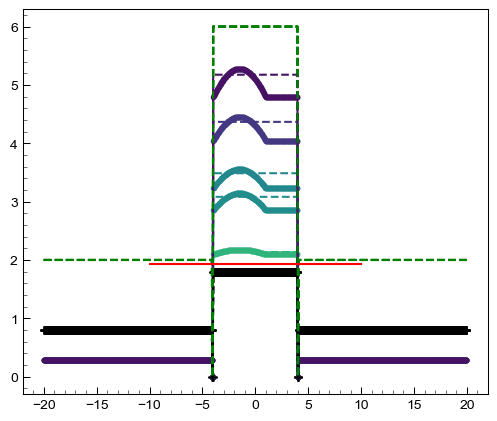

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))


for gougeevent_id in gougeevent_ids:
    key_tr = f"fb03-087__{gougeevent_id:04d}"
    
    lc = lc_dict[key_tr]
    ax.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_tau0"]/1e6, ls="-", marker=".", c=lc)
    ax.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_taup"]/1e6, ls="--", c=lc)
    ax.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_taur"]/1e6, ls="--", marker="+", c="k")
    ax.plot(crosssec_all["xvec"]*1e3, -crosssec_all[key_tr+"_sn"]/1e6, ls="--", marker="", c="g")
    
ax.plot([-10, 10], [tau_min_nuc/1e6, tau_min_nuc/1e6], "r-") # minimum stress to cause the spontaneous rupture
# ax.set_xlim([0, 4])

# Plot contour and cross-section profile

In [52]:
gougeevent_ids

[24, 50, 52, 72, 129]

In [53]:
# Compute average of nucleation radius
rnuc_patch_all = []
for gougeevent_id in gougeevent_ids:
    key_tr = f"fb03-087__{gougeevent_id:04d}"
    rnuc_patch_all.append(df_modelparam.loc[gougeevent_id, :].rnuc_patch)
    
mean_rnuc_patch = np.mean(rnuc_patch_all)
print(rnuc_patch_all, f"rnuc mean = {mean_rnuc_patch:.2f}mm")

[1.63134761, 1.1234049, 1.07633824, 0.964979935, 0.897392765] rnuc mean = 1.14mm


In [54]:
# Show the grid resolution to the Rc
print(f"Grid size:{dgrid*1e3:.5f} mm, The grid size is at least {np.min(np.array(rnuc_patch_all)*1e-3/dgrid):.1f} ")

Grid size:0.03906 mm, The grid size is at least 23.0 


In [55]:
rnuc_patch_all

[1.63134761, 1.1234049, 1.07633824, 0.964979935, 0.897392765]

In [56]:
dgrid

3.90625e-05

In [57]:
df_modelparam_selected.columns

Index(['M0_mean', 'Tw_mean', 'Mw_mean', 'hat_sn_patch', 'hat_sn_background',
       'delsig_withmargin_try', 'slip_try', 'initialstress_fraction',
       'delsigma_factor', 'fp_patch', 'hat_fr', 'hat_fp_background',
       'hat_fr_background', 'dc_try', 'hat_ds_factor_rapidnuc_nuc',
       'hat_ds_factor_rapidnuc_patch', 'tau_c_nuc', 'tau_r_nuc', 'tau_c_patch',
       'tau_r_patch', 'tau_c_background', 'tau_r_background', 'tau_0_nuc',
       'tau_0_patch', 'tau_0_background', 'GIIC_nuc', 'GIIC_patch',
       'GIIC_background', 'Sratio_nuc', 'Sratio_patch', 'Ainit_nuc',
       'Ainit_patch', 'Anuc_nuc', 'Anuc_patch', 'rnuc_nuc', 'rnuc_patch'],
      dtype='object')

**Update:** we plot the figures horizontally for the master plot.

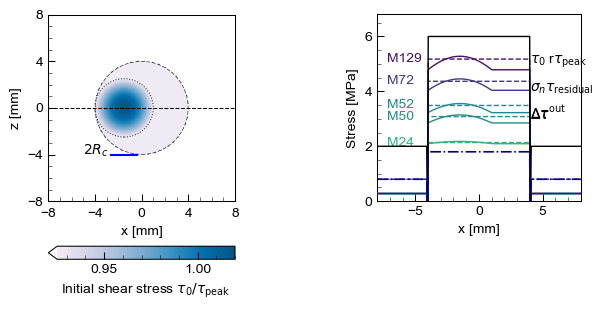

In [58]:
gougeevent_id_master = 72 #104 # all event shows same result as the value is normalized
df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id_master]
key_tr_master = f"fb03-087__{gougeevent_id_master:04d}"

tau_0_patch = df_modelparam_selected['tau_0_patch'].values[0]
tau_c_patch = df_modelparam_selected['tau_c_patch'].values[0]

# ref: https://matplotlib.org/stable/gallery/axes_grid1/scatter_hist_locatable_axes.html
fig, (ax, ax_crosssec) = plt.subplots(1, 2, figsize=(8.0, 3.2), gridspec_kw={'width_ratios': [1.07, 0.36]} )#(8, 7))


#1. Plot 2D stress distribution
divider = make_axes_locatable(ax)

# ref: https://matplotlib.org/stable/gallery/axes_grid1/demo_colorbar_with_axes_divider.html
cax1 = divider.append_axes("bottom", size="7%", pad=0.45)
# cax1 = divider.append_axes("right", size="7%", pad="5%")

# to align the figure, we also divide the cross-section axis
divider_crosssec = make_axes_locatable(ax_crosssec)

cax2 = divider_crosssec.append_axes("bottom", size="7%", pad=0.45)
cax2.axis("off")

# right
# ax_crosssec = divider.append_axes("right", 2.4, pad="5%")

vmin_eps = 1e-4 # to color the patch region where tau = 0.925tau_peak
vmax_cvt = 1.02 # the range is upto 1.02 for the master model
vmin_cvt = 0.925 - vmin_eps

# ref: https://stackoverflow.com/a/18926541
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))

    return new_cmap

# cmap = plt.get_cmap('inferno_r') To avoid the confusion with the snapshots of cohesion
cmap = plt.get_cmap('PuBu')
cmap_cvt = truncate_colormap(cmap, 0.1, 0.9)

# background color
# cmap_cvt.set_under([0.85, 0.85, 0.85],1.)
# cmap_cvt.set_bad([0.8, 0.8, 0.8],1.)
# cmap_cvt.set_under([0.96, 0.96, 0.96], 1.)
cmap_cvt.set_under("w", 1.)
# cmap_cvt.set_bad([1, 1, 1],1.)

h3 = ax.pcolormesh(X*1e3, Z*1e3, crosssec_all[key_tr_master+"_V_coh"]/tau_c_patch, norm=colors.Normalize(vmin=vmin_cvt, vmax=vmax_cvt), cmap=cmap_cvt, rasterized=True)

ax.set_xlabel("x [mm]")
ax.tick_params(axis='x', pad=5)

ax.set_ylabel("z [mm]")
ax.tick_params(axis='y', labelleft=True)

ax.set_aspect('equal', 'box')

xlimit=[-8, 8]
ax.set_xlim(xlimit)
ax.set_ylim(xlimit) # same as x limit

ax.set_xticks(np.linspace(-8, 8, 5))
ax.set_yticks(np.linspace(-8, 8, 5))
   
line_patch = plt.Circle((0, 0), a_patch*1e3, ec=[0.2, 0.2, 0.2], fill=False, ls="--", lw=0.75)
line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec=[0.2, 0.2, 0.2], fill=False, ls=":", lw=0.75)
line_margin = plt.Circle((0, 0), a_margin*1e3, ec='w', fill=False, ls="--")

ax.add_patch(line_patch)
ax.add_patch(line_nuc)
ax.add_patch(line_margin)

titlestr=f"ID: {gougeevent_id_master}"
# ax.set_title(titlestr)

# color bars
# vel
cticks = [0.001, 0.01, 0.1]
cticklabels= [str(x) for x in cticks]

# shear stress over the peak frictional strength
cb_cvt = fig.colorbar(h3, cax=cax1, orientation="horizontal", shrink=1.0, # ticks=[1, 1.1, 1.2],
                     extend='min', extendrect=False, ticks=[0.95, 1.0])

cb_cvt.set_label(r"Initial shear stress $τ_0/τ_{\mathrm{peak}}$")

# plot length scale
# ax.plot([-a_patch*1e3, a_patch*1e3], [-6, -6], "k-")
# ax.plot([-(a_nuc-nuc_x)*1e3, (a_nuc+nuc_x)*1e3], [-5, -5], "g-")
ax.plot([(nuc_x-mean_rnuc_patch*1e-3)*1e3, (nuc_x+mean_rnuc_patch*1e-3)*1e3], [-4, -4], "b-")

# Plot cross-section line
ax.plot(xlimit, [0, 0], "k--", lw=0.75, zorder=2)

rnuc_patch_all

# ax.axis("off")
#--------------------#
#2. Plot cross-section
#--------------------#

# Plot cross-section
for gougeevent_id in gougeevent_ids:
    key_tr = f"fb03-087__{gougeevent_id:04d}"
    lc = lc_dict[key_tr]
    ax_crosssec.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_tau0"]/1e6, c=lc, lw=1, zorder=3)
    
    # isolate the background peak friction as this is similar for all the case
    patch_inds = np.abs(crosssec_all["xvec"])<=a_margin
    
    if gougeevent_id==129:
        # plot entire peak friction
        ax_crosssec.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_taup"]/1e6, ls="--", c=lc, lw=1) # marker="+",
    else:
        # plot only inside the patch and margin
        ax_crosssec.plot(crosssec_all["xvec"][patch_inds]*1e3, crosssec_all[key_tr+"_taup"][patch_inds]/1e6, ls="--", c=lc, lw=1) # marker="+",

    # Annotate the event IDs
    ax_crosssec.text(-7.2, np.max(crosssec_all[key_tr+"_taup"])/1e6, f"M{gougeevent_id:02d}", c=lc, va="center")
    
# plot residual friction level: it is set the same for all the events
key_tr = f"fb03-087__{gougeevent_id_master:04d}"
ax_crosssec.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_taur"]/1e6, c="darkblue", ls="dashdot", lw=1.2, zorder=5)

# plot normal stress
ax_crosssec.plot(crosssec_all["xvec"]*1e3, -crosssec_all[key_tr+"_sn"]/1e6, c="k", ls="-", lw=1, zorder=3)

# plot minimum shear stress to cause the spontaneous rupture
# ax_crosssec.plot(np.array([-a_patch, a_patch])*1e3 + [-tauminmargin, tauminmargin], np.array([tau_min_nuc, tau_min_nuc])/1e6, c="b", ls="-", lw=1, zorder=1)

# ax_crosssec.plot(-7.7 , tau_min_nuc/1e6, c="r", marker="<", zorder=1) # skip plotting

# ax_crosssec.axhline(1.0, ls="--", c='gray', lw=1)

# annotate texts
text_x = 4.0
ax.text(-5, -4, r"$2R_c$")
ax_crosssec.text(text_x, 5, r"$\tau_0$ r$\tau_{\mathrm{peak}}$")
ax_crosssec.text(text_x, 4, r"$\sigma_n \tau_{\mathrm{residual}}$")
ax_crosssec.text(text_x, 3, r"$\Delta \tau$")
ax_crosssec.text(text_x, 3, r"$\Delta \tau^{\text{out}}$")

ax_crosssec.set_xlim([-8, 8])
ax_crosssec.set_ylim([0., 6.8])

ax_crosssec.set_xlabel("x [mm]")
# ax_crosssec.set_ylabel("$τ_{yx}^{0}/τ_{yx}^p$")
# ax_crosssec.set_ylabel("$τ_{0} / τ_p$")
ax_crosssec.set_ylabel("Stress [MPa]")


# axs[1, 1].axis("off")

# fig.align_ylabels(axs[:, -1])

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
fig.tight_layout() # this reset the figure margins

plt.savefig(figdir + f"/master_initialcondition_event{gougeevent_id_master:d}_crosssec_ele{nb_x_elements}_verticalcb{filekey}.png", dpi=300, bbox_inches="tight")
plt.savefig(figdir + f"/master_initialcondition_event{gougeevent_id_master:d}_crosssec_ele{nb_x_elements}_verticalcb{filekey}.eps", bbox_inches="tight")


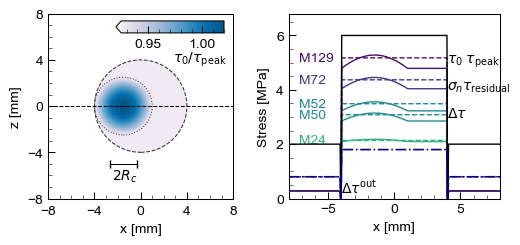

In [70]:
gougeevent_id_master = 72 #104 # all event shows same result as the value is normalized
df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id_master]
key_tr_master = f"fb03-087__{gougeevent_id_master:04d}"

tau_0_patch = df_modelparam_selected['tau_0_patch'].values[0]
tau_c_patch = df_modelparam_selected['tau_c_patch'].values[0]

# ref: https://matplotlib.org/stable/gallery/axes_grid1/scatter_hist_locatable_axes.html
fig, (ax, ax_crosssec) = plt.subplots(1, 2, figsize=(6, 2.4), gridspec_kw={'width_ratios': [0.5, 0.5]} )#(8, 7))


#1. Plot 2D stress distribution
# divider = make_axes_locatable(ax)

# ref: https://matplotlib.org/stable/gallery/axes_grid1/demo_colorbar_with_axes_divider.html
# cax1 = divider.append_axes("bottom", size="7%", pad=0.45)
# cax1 = divider.append_axes("right", size="7%", pad="5%")

# to align the figure, we also divide the cross-section axis
# divider_crosssec = make_axes_locatable(ax_crosssec)

# cax2 = divider_crosssec.append_axes("bottom", size="7%", pad=0.45)
# cax2.axis("off")

# right
# ax_crosssec = divider.append_axes("right", 2.4, pad="5%")

vmin_eps = 1e-4 # to color the patch region where tau = 0.925tau_peak
vmax_cvt = 1.02 # the range is upto 1.02 for the master model
vmin_cvt = 0.925 - vmin_eps

# ref: https://stackoverflow.com/a/18926541
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))

    return new_cmap

# cmap = plt.get_cmap('inferno_r') To avoid the confusion with the snapshots of cohesion
cmap = plt.get_cmap('PuBu')
cmap_cvt = truncate_colormap(cmap, 0.1, 0.9)

# background color
# cmap_cvt.set_under([0.85, 0.85, 0.85],1.)
# cmap_cvt.set_bad([0.8, 0.8, 0.8],1.)
# cmap_cvt.set_under([0.96, 0.96, 0.96], 1.)
cmap_cvt.set_under("w", 1.)
# cmap_cvt.set_bad([1, 1, 1],1.)

h3 = ax.pcolormesh(X*1e3, Z*1e3, crosssec_all[key_tr_master+"_V_coh"]/tau_c_patch, norm=colors.Normalize(vmin=vmin_cvt, vmax=vmax_cvt), cmap=cmap_cvt, rasterized=True)

ax.set_xlabel("x [mm]")
ax.tick_params(axis='x', pad=5)

ax.set_ylabel("z [mm]")
ax.tick_params(axis='y', labelleft=True)

ax.set_aspect('equal', 'box')

xlimit=[-8, 8]
ax.set_xlim(xlimit)
ax.set_ylim(xlimit) # same as x limit

ax.set_xticks(np.linspace(-8, 8, 5))
ax.set_yticks(np.linspace(-8, 8, 5))
   
line_patch = plt.Circle((0, 0), a_patch*1e3, ec=[0.2, 0.2, 0.2], fill=False, ls="--", lw=0.75)
line_nuc = plt.Circle((nuc_x*1e3, nuc_z), a_nuc*1e3, ec=[0.2, 0.2, 0.2], fill=False, ls=":", lw=0.75)
line_margin = plt.Circle((0, 0), a_margin*1e3, ec='w', fill=False, ls="--")

ax.add_patch(line_patch)
ax.add_patch(line_nuc)
# ax.add_patch(line_margin)

titlestr=f"ID: {gougeevent_id_master}"
# ax.set_title(titlestr)

# color bars
# vel
cticks = [0.001, 0.01, 0.1]
cticklabels= [str(x) for x in cticks]

# shear stress over the peak frictional strength
# set color bar inside the axis
axins1 = fig.add_axes([0.26, .8, .18, .05])
cb_cvt = fig.colorbar(h3, cax=axins1, orientation="horizontal", shrink=1.0,
                      extend='min', extendrect=False, ticks=[0.95, 1.0])
cb_cvt.set_label(r"$τ_0/τ_{\mathrm{peak}}$", ha="left", labelpad=0)


# cb_cvt = fig.colorbar(h3, cax=cax1, orientation="horizontal", shrink=1.0, # ticks=[1, 1.1, 1.2],
#                      extend='min', extendrect=False, ticks=[0.95, 1.0])

# cb_cvt.set_label("Initial shear stress $τ_0/τ_{\mathrm{peak}}$")



# plot length scale
# ax.plot([-a_patch*1e3, a_patch*1e3], [-6, -6], "k-")
# ax.plot([-(a_nuc-nuc_x)*1e3, (a_nuc+nuc_x)*1e3], [-5, -5], "g-")
rnuc_scale_y = -5
ax.plot([(nuc_x-mean_rnuc_patch*1e-3)*1e3, (nuc_x+mean_rnuc_patch*1e-3)*1e3], [rnuc_scale_y, rnuc_scale_y], "k-", lw=0.75, marker="|")

# Plot cross-section line
ax.plot(xlimit, [0, 0], "k--", lw=0.75, zorder=2)

rnuc_patch_all

# ax.axis("off")
#--------------------#
#2. Plot cross-section
#--------------------#

# Plot cross-section
for gougeevent_id in gougeevent_ids:
    key_tr = f"fb03-087__{gougeevent_id:04d}"
    lc = lc_dict[key_tr]
    ax_crosssec.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_tau0"]/1e6, c=lc, lw=1, zorder=3)
    
    # isolate the background peak friction as this is similar for all the case
    patch_inds = np.abs(crosssec_all["xvec"])<=a_margin
    
    if gougeevent_id==129:
        # plot entire peak friction
        ax_crosssec.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_taup"]/1e6, ls="--", c=lc, lw=1) # marker="+",
    else:
        # plot only inside the patch and margin
        ax_crosssec.plot(crosssec_all["xvec"][patch_inds]*1e3, crosssec_all[key_tr+"_taup"][patch_inds]/1e6, ls="--", c=lc, lw=1) # marker="+",

    # Annotate the event IDs
    ax_crosssec.text(-7.2, np.max(crosssec_all[key_tr+"_taup"])/1e6, f"M{gougeevent_id:02d}", c=lc, va="center")
    
# plot residual friction level: it is set the same for all the events
key_tr = f"fb03-087__{gougeevent_id_master:04d}"
ax_crosssec.plot(crosssec_all["xvec"]*1e3, crosssec_all[key_tr+"_taur"]/1e6, c="darkblue", ls="dashdot", lw=1.2, zorder=5)

# plot normal stress
ax_crosssec.plot(crosssec_all["xvec"]*1e3, -crosssec_all[key_tr+"_sn"]/1e6, c="k", ls="-", lw=1, zorder=3)

# plot minimum shear stress to cause the spontaneous rupture
# ax_crosssec.plot(np.array([-a_patch, a_patch])*1e3 + [-tauminmargin, tauminmargin], np.array([tau_min_nuc, tau_min_nuc])/1e6, c="b", ls="-", lw=1, zorder=1)
# ax_crosssec.plot(-7.7 , tau_min_nuc/1e6, c="r", marker="<", zorder=1) # skip plot critical size

# ax_crosssec.axhline(1.0, ls="--", c='gray', lw=1)

# annotate texts
text_x = 4.0
ax.text(-2.5, -6.4, r"$2R_c$")
ax_crosssec.text(text_x, 5, r"$\tau_0$ $\tau_{\mathrm{peak}}$")
ax_crosssec.text(text_x, 4, r"$\sigma_n \tau_{\mathrm{residual}}$")
ax_crosssec.text(text_x, 3, r"$\Delta \tau$")
ax_crosssec.text(-text_x, 0.2, r"$\Delta \tau^{\text{out}}$")

ax_crosssec.set_xlim([-8, 8])
ax_crosssec.set_ylim([0., 6.8])

ax_crosssec.set_xlabel("x [mm]")
# ax_crosssec.set_ylabel("$τ_{yx}^{0}/τ_{yx}^p$")
# ax_crosssec.set_ylabel("$τ_{0} / τ_p$")
ax_crosssec.set_ylabel("Stress [MPa]")


# axs[1, 1].axis("off")

# fig.align_ylabels(axs[:, -1])

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# fig.tight_layout() # this reset the figure margins

plt.savefig(figdir + f"/master_initialcondition_event{gougeevent_id_master:d}_crosssec_ele{nb_x_elements}_horizcb_in{filekey}.png", dpi=300, bbox_inches="tight")
plt.savefig(figdir + f"/master_initialcondition_event{gougeevent_id_master:d}_crosssec_ele{nb_x_elements}_horizcb_in{filekey}.eps", bbox_inches="tight")


# Compute the stats of the cross-section

We compute the stats of cross-section for the discussion. We evaluate $\tau_p - \tau_r$. However, it should be noted that the final stress with the self-healing friction is different from these stats, which will be evaluated in the different notebook.

In [60]:
patch_inds = np.where(np.abs(crosssec_all["xvec"]) < a_patch)
patch_inds
deltau_patch_all = []
for gougeevent_id in gougeevent_ids:
    
    df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id]
    simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"
    print(f"Process {gougeevent_id}: {simulation_name}")

    # key_tr = f"{df_modelparam_selected.index[0]}"
    key_tr = f"fb03-087__{df_modelparam_selected.index[0]:04d}"

    tau0_cross = crosssec_all[key_tr+"_tau0"]
    taup_cross = crosssec_all[key_tr+"_taup"]
    taur_cross = crosssec_all[key_tr+"_taur"]
    tau0_cross_patch_mean = np.mean(tau0_cross[patch_inds])
    taup_cross_patch_mean = np.mean(taup_cross[patch_inds])
    taur_cross_patch_mean = np.mean(taur_cross[patch_inds])
    deltau_patch_all.append(tau0_cross_patch_mean - taur_cross_patch_mean)

Process 24: fb03-087__0024_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35
Process 50: fb03-087__0050_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35
Process 52: fb03-087__0052_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35
Process 72: fb03-087__0072_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35
Process 129: fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35


In [61]:
print("patch tau0-taur =", np.array(deltau_patch_all)/1e6, "MPa")

patch tau0-taur = [0.32929675 1.1719035  1.562244   2.410913   3.1903665 ] MPa


In [62]:
# Evaluate negative stress drop
sn_background = 2e6
fp_background = 0.4
barrier_delsig = (sn_background * fp_background) * (1-bgbeta)
print(barrier_delsig/1e6)
barrier_delsig / np.array(deltau_patch_all)

0.52


array([1.57912278, 0.44372254, 0.33285453, 0.21568592, 0.16299068])

In [63]:
3.144532

3.144532

In [64]:
a_patch

0.004

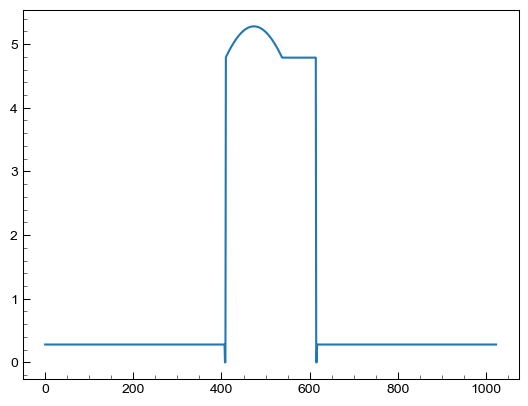

In [65]:
plt.plot(crosssec_all[key_tr+"_tau0"]/1e6)

In [66]:
crosssec_all[key_tr+"_tau0"]/1e6

array([0.28, 0.28, 0.28, ..., 0.28, 0.28, 0.28], dtype=float32)

In [67]:
mean_rnuc_patch

1.1386926899999998

In [68]:
nuc_x

-0.0015